<a href="https://colab.research.google.com/github/Rankyer/Perceptron_data_pruning_theory/blob/main/Perceptron_data_pruning_theory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
sns.set(style='ticks',font_scale=1.2)

import cvxpy as cp
from scipy.integrate import quad, dblquad
from scipy.special import erfc, erfinv
from scipy.optimize import root

def H(x):
    return 1/2*erfc(x/np.sqrt(2))

def solve_perceptron(X,y):
    N = X.shape[0]

    # Convex optimization
    w_var = cp.Variable(N)
    yhat = w_var@X
    loss = cp.sum(cp.pos(-cp.multiply(yhat,y)))
    prob = cp.Problem(
            cp.Minimize(cp.norm2(w_var)),
            [cp.multiply(y,yhat) >= 1]
    )
    prob.solve()
    w = w_var.value

    compute_time = prob.solver_stats.setup_time+prob.solver_stats.solve_time

    return w, compute_time

# Perfect teacher-probe overlap

The solution is given by the following saddle point equations,

\begin{equation}
R=\frac{2\alpha}{f\sqrt{2\pi}\sqrt{1-R^{2}}}\int_{-\infty}^{\kappa}Dt\ \exp\bigg(-\frac{R^{2}t^{2}}{2(1-R^{2})}\bigg)\bigg[1-\exp\bigg(-\frac{\gamma(\gamma-2Rt)}{2(1-R^{2})}\bigg)\bigg](\kappa-t)
\end{equation}

\begin{equation}
1-R^{2}=\frac{2\alpha}{f}\int_{-\infty}^{\kappa}Dt\ \bigg[H\bigg(-\frac{Rt}{\sqrt{1-R^{2}}}\bigg)-H\bigg(-\frac{Rt-\gamma}{\sqrt{1-R^{2}}}\bigg)\bigg](\kappa-t)^{2}
\end{equation}

In [ ]:
def intg1(t,k,R,kthresh):
    measure = np.exp(-t**2/(2*(1-R**2)))*(np.exp(kthresh*(2*R*t-kthresh)/(2*(1-R**2)))-1)/(2*np.pi)
    integrand = (t-k)/f
    return measure*integrand

def intg2(t,k,R,kthresh):
    measure = np.exp(-t**2/2)/np.sqrt(2*np.pi)*(1-H((kthresh-R*t)/np.sqrt(1-R**2))-H(R*t/np.sqrt(1-R**2)))
    integrand = (k-t)**2/f
    return measure*integrand

def eq1(k,R,alpha,kthresh):
    intg,tol = quad(intg1,-np.inf,k,args=(k,R,kthresh))
    rhs = 2*alpha*intg/np.sqrt(1-R**2)
    lhs = R
    return rhs - lhs

def eq2(k,R,alpha,kthresh):
    intg,tol = quad(intg2,-np.inf,k,args=(k,R,kthresh))
    rhs = 2*alpha*intg
    lhs = 1-R**2
    return rhs - lhs

def eq(args,alpha,kthresh):
    k,R = args
    return eq1(k,R,alpha,kthresh)**2 + eq2(k,R,alpha,kthresh)**2

def eq_root(args,alpha,kthresh):
    k,R = args
    if 1e-10<R<1-1e-10:
      return eq1(k,R,alpha,kthresh), eq2(k,R,alpha,kthresh)
    elif R<=1e-10:
      return -R**2,-R**2
    else:
      return R**2,R**2

In [ ]:
Rs = []
Rtheory = []
times_all = []
fs = np.logspace(-1,0,10)
# fs = np.linspace(0.1,1,10)
navg = 100
alphas = np.logspace(0.1,0.5,30)
for alpha in tqdm(alphas):
  for f in fs:
    kthresh = erfinv(f)*np.sqrt(2)
    Rtmp = []
    ktmp = []
    for _ in range(navg):
      N = 200
      P = int(alpha*N)
      X = np.random.randn(N,P)/np.sqrt(N)

      # Prune
      a = np.random.randn(100000)/np.sqrt(N)
      X[0] = a[np.abs(a)<kthresh/np.sqrt(N)][:P]
#             prune_idxs = np.where(np.abs(X[0])<kthresh/np.sqrt(N))[0]
#             Xprune = X[:,prune_idxs]
      w_teacher = np.zeros(N)
      w_teacher[0] = 1
      y = np.sign(w_teacher@X)
      w_student,compute_time = solve_perceptron(X,y)
      R = np.corrcoef([w_student,w_teacher])[0,1]
      k = np.sqrt(N)/np.linalg.norm(w_student)
      Rtmp.append(R)
      ktmp.append(k)
      times_all.append(compute_time)
    Rs.append(np.mean(Rtmp))

    # Theory
    out = root(eq_root,(np.mean(ktmp),np.mean(Rtmp)),args=(alpha,kthresh))
    if out.success:
      k,R = out.x
    else:
      R = np.nan
    Rtheory.append(R)
Rs = np.stack(Rs).reshape(len(alphas),len(fs))
Rtheory = np.stack(Rtheory).reshape(len(alphas),len(fs))
times_all = np.stack(times_all).reshape(len(alphas),len(fs),navg)

  0%|          | 0/30 [00:00<?, ?it/s]

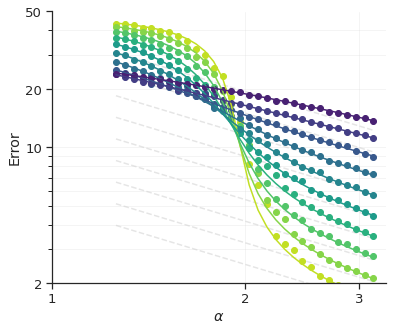

In [ ]:
# plt.axvline(np.sqrt(N)/2)
with sns.color_palette('viridis_r', len(fs)):
  plt.figure(figsize=(6,5))
  for i in range(len(fs)):
      plt.scatter(alphas,100*np.arccos(Rs[:,i])/np.pi,label=str(int(np.round(100*fs[i])))+'%')
      plt.plot(alphas[Rtheory[:,i]>0],100*np.arccos(Rtheory[:,i][Rtheory[:,i]>0])/np.pi)
      if i<len(fs)-1:
          plt.plot(alphas,100*0.5*fs[i]/alphas,linestyle='dashed',c='grey',alpha=0.2,zorder=-99)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Error')
plt.xlabel(r'$\alpha$')
# plt.legend();
plt.xticks([1,2,3],[1,2,3])
plt.yticks([2,10,20,50],[2,10,20,50])
plt.ylim([2,50])
plt.grid(True,which='both',alpha=0.2)
sns.despine()
from google.colab import files
# plt.savefig("perceptron_pruning.pdf",transparent='True')
# files.download("perceptron_pruning.pdf")

## Compute

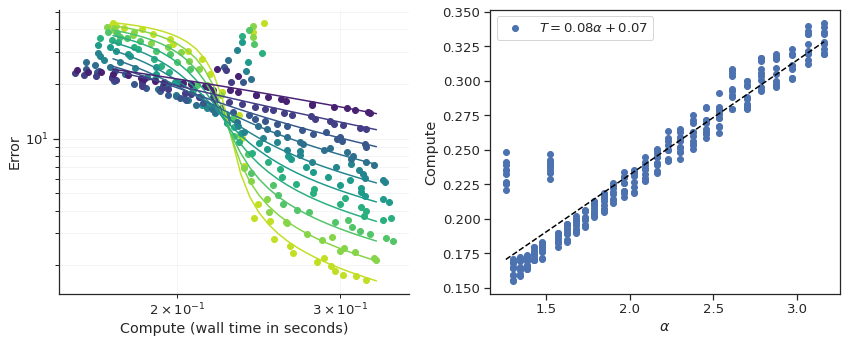

In [ ]:
from scipy.stats import linregress
m,b,r,p,_ = linregress(np.tile(alphas[:,None],10).ravel(),times_all.mean(-1).ravel())

# plt.axvline(np.sqrt(N)/2)
with sns.color_palette('viridis_r', len(fs)):
  plt.figure(figsize=(12,5))
  plt.subplot(121)
  for i in range(len(fs)):
      plt.scatter(times_all[:,i].mean(-1),100*np.arccos(Rs[:,i])/np.pi,
               label=str(int(np.round(100*fs[i])))+'%')
      plt.plot(b+m*alphas[Rtheory[:,i]>0],100*np.arccos(Rtheory[:,i][Rtheory[:,i]>0])/np.pi)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Error')
plt.xlabel('Compute (wall time in seconds)')
# plt.legend();
# plt.xticks([1,2,3],[1,2,3])
# plt.yticks([2,10,20,50],[2,10,20,50])
# plt.xlim([7e-2,2.5e-1])
plt.grid(True,which='both',alpha=0.2)
sns.despine()


plt.subplot(122)
plt.scatter(np.tile(alphas[:,None],10),times_all.mean(-1),
            label=r'$T={:.2f}\alpha + {:.2f}$'.format(m,b))
plt.plot(alphas,alphas*m+b,c='black',linestyle='dashed')
plt.xlabel(r'$\alpha$')
plt.ylabel('Compute')
plt.legend();
plt.tight_layout()

## Fixed dataset size

In [ ]:
N = 100
Rs = []
Rtheory = []
fs = np.linspace(0.2,1,9)
navg = 100
for f in tqdm(fs):
    alphas = f*np.logspace(0,np.log10(3.5/0.2),20)
    for alpha in tqdm(alphas,leave=False):
        kthresh = erfinv(f)*np.sqrt(2)
        for _ in range(navg):
            P = int(alpha*N)

            # Generate training examples
            X = np.random.randn(N,P)/np.sqrt(N)

            # Prune along teacher direction (1,0,...,0)
#             X = X[:,np.abs(X[0]).argsort()[:int(P*f)]]
            a = np.random.randn(10000)/np.sqrt(N)
            X[0] = a[np.abs(a)<kthresh/np.sqrt(N)][:P]
            w_teacher = np.zeros(N)
            w_teacher[0] = 1
            y = np.sign(w_teacher@X)
            w_student,_ = solve_perceptron(X,y)
            Rs.append(np.corrcoef([w_student,w_teacher])[0,1])

        out = root(eq_root,(0,0.9),args=(alpha,kthresh))
        k,R = out.x
        if out.success:
            Rtheory.append(R)
        else:
            Rtheory.append(np.nan)

Rs = np.stack(Rs).reshape(len(fs),len(alphas),navg).mean(-1)
Rtheory = np.stack(Rtheory).reshape(len(fs),len(alphas))

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

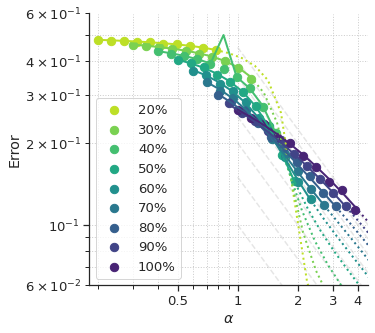

In [ ]:
with sns.color_palette('viridis_r', len(fs)):
    plt.figure(figsize=(5,5))
    for i in range(len(fs)):
        # Extrapolation
        plt.plot(alphas[9:]*fs[i],np.arccos(Rtheory[i])[9:]/np.pi,linewidth=2,
                alpha=1,linestyle='dotted')
    for i in range(len(fs)):
        plt.plot(alphas[:10]*fs[i],np.arccos(Rtheory[i])[:10]/np.pi,linewidth=2)
        plt.scatter(alphas[:10]*fs[i],np.arccos(Rs[i])[:10]/np.pi,
                 label=str(int(np.round(100*fs[i])))+'%',s=70)
        if i<len(fs)-1:
            plt.plot(alphas,0.5*fs[i]/alphas,linestyle='dashed',c='grey',alpha=0.2,zorder=-99)

plt.xscale('log')
plt.yscale('log')
plt.ylabel('Error')
plt.xlabel(r'$\alpha$')
plt.xticks([0.5,1,2,3,4],[0.5,1,2,3,4])
plt.xlim([0.18,4.5])
plt.ylim([6e-2,6e-1])
plt.grid(True, which="both", ls=":")
sns.despine();
plt.legend()
# plt.savefig('images/perceptron_scaling_extrap2.pdf')

# Imperfect overlap with teacher

When the probe student does not perfectly match the teacher, we have an extra parameter $\theta$ which characterizes the angle between the probe student and the teacher, and an extra order parameter $\rho=J_\text{probe}\cdot J$ which characterizes the typical student-probe overlap, and must be optimized over. Hence we end up with three saddle point equations,


\begin{align}
\frac{R-\rho\cos\theta}{\sin^{2}\theta}&=\frac{\alpha}{\pi\Lambda}\bigg<\int_{-\infty}^{\kappa}dt\ \exp\left(-\frac{\Delta(t,z)}{2\Lambda^{2}}\right)(\kappa-t)\bigg>_{z} \\
1-\frac{\rho^{2}+R^{2}-2\rho R\cos\theta}{\sin^{2}\theta}&=2\alpha\bigg<\int_{-\infty}^{\kappa}dt\frac{e^{-\frac{(t-\rho z)^{2}}{2(1-\rho^{2})}}}{\sqrt{2\pi}\sqrt{1-\rho^{2}}}H\bigg(\frac{\Gamma(t,z)}{\sqrt{1-\rho^{2}}\Lambda}\bigg)(\kappa-t)^{2}\bigg>_{z}  \\
\frac{\rho-R\cos\theta}{\sin^{2}\theta}&=2\alpha\bigg<\int_{-\infty}^{\kappa}dt\frac{e^{-\frac{(t-\rho z)^{2}}{2(1-\rho^{2})}}}{\sqrt{2\pi}\sqrt{1-\rho^{2}}}H\bigg(\frac{\Gamma(t,z)}{\sqrt{1-\rho^{2}}\Lambda}\bigg)\bigg(\frac{z-\rho t}{1-\rho^{2}}\bigg)(\kappa-t) \nonumber \\
& \quad \quad \quad +\frac{1}{2\pi\Lambda}\exp\left(-\frac{\Delta(t,z)}{2\Lambda^{2}}\right)\bigg(\frac{\rho R-\cos\theta}{1-\rho^{2}}\bigg)(\kappa-t)\bigg>_{z}
\end{align}

Where,
\begin{align}
\Lambda&=\sqrt{\sin^{2}\theta-R^{2}-\rho^{2}+2\rho R\cos\theta}, \\
\Gamma(t,z)&=z(\rho R-\cos\theta)-t(R-\rho\cos\theta), \\
\Delta(t,z)&=z^{2}\left(\rho^{2}+\cos^{2}\theta-2\rho R\cos\theta\right)+2tz(R\cos\theta-\rho)+t^{2}\sin^{2}\theta.
\end{align}

In [ ]:
from scipy.special import erf, erfinv

def Theta(x):
    return (np.sign(x)+1)/2

def p(x):
    dist = np.exp(-x**2/2)/np.sqrt(2*np.pi)
    return dist*Theta(kthresh-np.abs(x))/f

In [ ]:
def intg_q(t,z,k,R,rho,R0,):
    A = 1-rho**2-R**2-R0**2+2*rho*R*R0
    tmeasure = np.exp(-(t-rho*z)**2/2/(1-rho**2))/np.sqrt(2*np.pi)/np.sqrt(1-rho**2)
    zmeasure = p(z)
    integrand = H(-(t*(R-rho*R0)-z*(rho*R-R0))/np.sqrt(1-rho**2)/np.sqrt(A))*(k-t)**2
    prefac = 2
    return tmeasure*zmeasure*integrand*prefac

def intg_R(t,z,k,R,rho,R0,):
    A = -(rho**2+R**2-2*rho*R*R0+R0**2-1)
    tmeasure = np.exp(-(z**2*(rho**2-2*rho*R*R0+R0**2)+2*t*z*(R*R0-rho)-(R0**2-1)*t**2)/2/A)
    zmeasure = p(z)
    prefac = 1/np.pi/np.sqrt(A)
    integrand = k-t

    return tmeasure*zmeasure*prefac*integrand


def intg_rho(t,z,k,R,rho,R0,):
    A = -(rho**2+R**2-2*rho*R*R0+R0**2-1)
    tmeasure = np.exp(-(t-rho*z)**2/2/(1-rho**2))/np.sqrt(2*np.pi)/np.sqrt(1-rho**2)
    zmeasure = p(z)
    integrand = H(-(t*(R-rho*R0)-z*(rho*R-R0))/np.sqrt(1-rho**2)/np.sqrt(A))*(z-rho*t)/(1-rho**2)*(k-t)
    prefac = 2
    term1 = tmeasure*zmeasure*prefac*integrand

    tmeasure = np.exp(-(z**2*(rho**2-2*rho*R*R0+R0**2)+2*t*z*(R*R0-rho)-(R0**2-1)*t**2)/2/A)
    zmeasure = p(z)
    prefac = -(R0-R*rho)/(1-rho**2)/np.pi/np.sqrt(A)
    integrand = k-t
    term2 = tmeasure*zmeasure*prefac*integrand

    return term1+term2


def eq_R(k,R,rho,R0,alpha):
    intg,tol = dblquad(intg_R,-kthresh,kthresh,-np.inf,k,args=(k,R,rho,R0))
    rhs = alpha*intg
    lhs = (R - rho*R0)/(1-R0**2)
    return rhs - lhs

def eq_q(k,R,rho,R0,alpha):
    intg,tol = dblquad(intg_q,-kthresh,kthresh,-np.inf,k,args=(k,R,rho,R0))
    rhs = alpha*intg
    lhs = 1-(rho**2+R**2-2*R0*R*rho)/(1-R0**2)
    return rhs - lhs

def eq_rho(k,R,rho,R0,alpha):
    intg,tol = dblquad(intg_rho,-kthresh,kthresh,-np.inf,k,args=(k,R,rho,R0))
    rhs = alpha*intg
    lhs = (rho-R*R0)/(1-R0**2)
    return rhs - lhs

def eq(args,R0,alpha):
    k,R,rho = args
    A = -(rho**2+R**2-2*rho*R*R0+R0**2-1)
    if R < 1-1e-8 and rho**2<1-1e-8 and k>1e-8 and A>1e-8:
        return eq_R(k,R,rho,R0,alpha), eq_q(k,R,rho,R0,alpha), eq_rho(k,R,rho,R0,alpha)
    else:
        return R**2+rho**2-1e3*k-1e3*A,R**2+rho**2-1e3*k-1e3*A,R**2+rho**2-1e3*k-1e3*A

In [ ]:
fs = np.logspace(-1,0,8)
navg = 100
alphas = np.logspace(np.log10(1),np.log10(8),15)

Rs = []
Rstheory = []
thetas = np.array([0,10,20])*np.pi/180
for theta in thetas:
  R0 = np.cos(theta)
  for alpha in tqdm(alphas):
    for f in fs:
      kthresh = erfinv(f)*np.sqrt(2)
      Rtmp = []
      ktmp = []
      rhotmp = []
      for _ in range(navg):
        N = 50
        P = int(alpha*N)
        X = np.random.randn(N,P)/np.sqrt(N)

        P = int(alpha*N)
        X = np.random.randn(N,P)/np.sqrt(N)
        a = np.random.randn(int(10000*alpha))/np.sqrt(N)
        X[0] = a[np.abs(a)<kthresh/np.sqrt(N)][:P]

        w_teacher = np.random.randn(N)
        w_teacher /= np.linalg.norm(w_teacher[1:])
        w_teacher *= np.sqrt(1-R0**2)
        w_teacher[0] = R0
        y = np.sign(w_teacher@X)
        w_student,_ = solve_perceptron(X,y)
        R = np.corrcoef([w_student,w_teacher])[0,1]
        w_prune = np.zeros(N)
        w_prune[0] = 1
        rho = np.corrcoef([w_student,w_prune])[0,1]
        rhotmp.append(rho)
        k = np.sqrt(N)/np.linalg.norm(w_student)
        Rtmp.append(R)
        ktmp.append(k)
      Rs.append(np.mean(Rtmp))
        # R0 = R

      if theta!=0:
        out = root(eq,(np.mean(ktmp),np.mean(Rtmp),np.mean(rhotmp)),args=(R0,alpha))
      else:
        out = root(eq_root,(np.mean(ktmp),np.mean(Rtmp)),args=(alpha,kthresh))
      if out.success:
          Rtheory = out.x[1]
      else:
          Rtheory = np.nan
      Rstheory.append(Rtheory)
Rs_prune = np.stack(Rs).reshape(len(thetas),len(alphas),len(fs))
Rstheory = np.stack(Rstheory).reshape(len(thetas),len(alphas),len(fs))

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
from scipy.special import erf, erfinv
from scipy.optimize import minimize
from scipy.optimize import root

def H(x):
    return 1/2*erfc(x/np.sqrt(2))

def f(k,R):
    lhs = -(np.exp(-k**2/2)*k*np.sqrt(2/np.pi)-erf(k/np.sqrt(2)))/(1-2*H(k))
    rhs = 1-R**2
    return rhs - lhs

In [ ]:
# thetas = np.array([0,10,20])*np.pi/180
f_effs = []
for theta in thetas[1:]:
    out = root(f,x0=1e-2,args=(np.cos(theta),))
    f_effs.append(erf(out.x/np.sqrt(2)))
f_effs = np.stack(f_effs).squeeze()
print(f_effs)

[0.23781475 0.45630621]


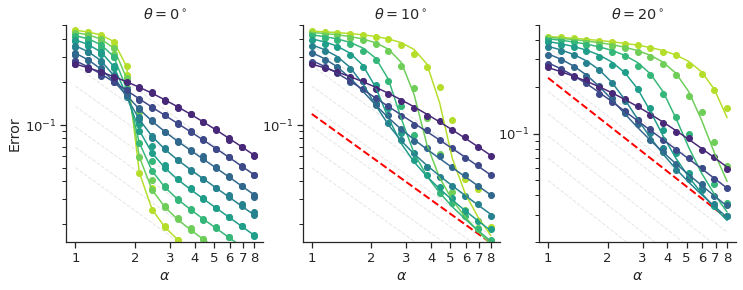

In [ ]:
# plt.axvline(np.sqrt(N)/2)
plt.figure(figsize=(12,4))

with sns.color_palette('viridis_r', len(fs)):
    plt.subplot(131)
    for i in range(len(fs)):
        plt.scatter(alphas,np.arccos(Rs_prune[0,:,i])/np.pi,label=str(int(np.round(100*fs[i])))+'%')
        plt.plot(alphas,np.arccos(Rstheory[0,:,i])/np.pi, 'o-',label=str(int(np.round(100*fs[i])))+'%')
        if i<len(fs)-1:
            plt.plot(alphas,0.5*fs[i]/alphas,linestyle='dashed',c='grey',alpha=0.2,zorder=-99,
                    linewidth=1)
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel('Error')
    plt.xlabel(r'$\alpha$')
    sns.despine()
    plt.title(r'$\theta=0^\circ$')
    plt.ylim(1.5e-2,5e-1)
    plt.xticks(ticks=np.arange(1,9),labels=np.arange(1,9))

    plt.subplot(132)
    for i in range(len(fs)):
        plt.scatter(alphas,np.arccos(Rs_prune[1,:,i])/np.pi,label=str(int(np.round(100*fs[i])))+'%')
        plt.plot(alphas,np.arccos(Rstheory[1,:,i])/np.pi,label=str(int(np.round(100*fs[i])))+'%')
        if i<len(fs)-1:
            plt.plot(alphas,0.5*fs[i]/alphas,linestyle='dashed',c='grey',alpha=0.2,zorder=-99,
                    linewidth=1)
    plt.plot(alphas,0.5*f_effs[0]/alphas,linestyle='dashed',c='red',zorder=-99,
            linewidth=2)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'$\alpha$')
    sns.despine()
    plt.title(r'$\theta=10^\circ$')
    plt.ylim(1.5e-2,5e-1)
    plt.xticks(ticks=np.arange(1,9),labels=np.arange(1,9))

    plt.subplot(133)
    for i in range(len(fs)):
        plt.scatter(alphas,np.arccos(Rs_prune[2,:,i])/np.pi,label=str(int(np.round(100*fs[i])))+'%')
        plt.plot(alphas,np.arccos(Rstheory[2,:,i])/np.pi,label=str(int(np.round(100*fs[i])))+'%')
        if i<len(fs)-1:
            plt.plot(alphas,0.5*fs[i]/alphas,linestyle='dashed',c='grey',alpha=0.2,zorder=-99,
                    linewidth=1)
    plt.plot(alphas,0.5*f_effs[1]/alphas,linestyle='dashed',c='red',zorder=-99,
            linewidth=2)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'$\alpha$')
    sns.despine()
    plt.title(r'$\theta=20^\circ$')
    plt.ylim(2e-2,5e-1)
    plt.xticks(ticks=np.arange(1,9),labels=np.arange(1,9))
# plt.savefig("imperfect_probe_theory.pdf",transparent='True')
# files.download("imperfect_probe_theory.pdf")

# Information gain per example

We define the amount of information gained from each new example, $I(\alpha)$, as the fraction by which the
space of solutions which perfectly classify the data is reduced when a new training example is added,
$I(\alpha)=\Omega(P+1)/\Omega(P)$. Or, equivalently, the rate at which the entropy is reduced, $I(\alpha)=−\frac{d}{d\alpha} S(\alpha)$. To compute the volume of the space of solutions we must relax the max-margin constraint above (which shrinks the space of solutions to a single optimum). We instead set the margin to zero, and study a setting called Gibbs learning, where a solution is selected at random from the space of solutions (see Appendix A.6 for details). We approximate Gibbs learning by first finding a max-margin solution, and then randomly perturbing this solution within the solution space using a monte carlo approach. The information gain is given by the following equation (Eq. 76 of main text):

$$ I(\alpha)=\frac{2\alpha}{f}\int Dt\ \bigg[H\bigg(\sqrt{\frac{R}{1-R}}t\bigg)-H\bigg(\frac{\gamma+\sqrt{R}t}{\sqrt{1-R}}\bigg)\bigg]\log H\bigg(\sqrt{\frac{R}{1-R}}t\bigg)\bigg] $$

where $\gamma=H^{-1}\bigg(\frac{1-f}{2}\bigg)$.

In [ ]:
eps = np.finfo(np.float32).eps
def info_intg(t,R,f,kthresh):
    measure = np.exp(-t**2/2)/np.sqrt(2*np.pi)
    a = -2*(H(np.sqrt(R/(1-R))*t)-H((kthresh+np.sqrt(R)*t)/np.sqrt(1-R)))*np.log(H(np.sqrt(R/(1-R))*t)+eps)/f
    return measure*a

In [ ]:
def monte_carlo(w):
    monte_carlo_count = 0
    for _ in range(10000):
        delta = 10/alpha**2*np.random.randn(N)/np.sqrt(N)
        w2 = w+delta
        if np.all(np.sign(w2@X)==y):
            w = w2
            monte_carlo_count+=1
        else:
            pass
    return w,monte_carlo_count

In [ ]:
N = 20
navg = 500
fs = np.logspace(-3,0,10)
infos = []
Rs_all = []
for f in tqdm(fs):
    kthresh = erfinv(f)*np.sqrt(2)
    alphas = np.linspace(1,3,12)
    Rs = []
    for alpha in tqdm(alphas,leave=False):
        for _ in range(navg):
            P = int(alpha*N)
            X = np.random.randn(N,P)/np.sqrt(N)
            a = np.random.randn(1000000)/np.sqrt(N)
            X[0] = a[np.abs(a)<kthresh/np.sqrt(N)][:P]
            w_teacher = np.zeros(N)
            w_teacher[0] = 1
            y = np.sign(w_teacher@X)
            try:
                w,_ = solve_perceptron(X,y)
                wmc,_ = monte_carlo(w)
                R = np.corrcoef(wmc,w_teacher)[0,1]
                Rs.append(R)
            except KeyboardInterrupt:
                break
            except:
                Rs.append(np.nan)
    Rs = np.nanmean(np.stack(Rs).reshape(len(alphas),-1),axis=-1)
    Rs_all.append(Rs)

    # Compute information gain
    for R in Rs:
        out = quad(info_intg,-np.inf,np.inf,args=(R,f,kthresh))
        infos.append(out[0])

infos = np.stack(infos).reshape(len(fs),len(alphas))
Rs_all = np.stack(Rs_all)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

<ipython-input-26-b7d096221bfe>:4: RuntimeWarning: invalid value encountered in sqrt
  a = -2*(H(np.sqrt(R/(1-R))*t)-H((kthresh+np.sqrt(R)*t)/np.sqrt(1-R)))*np.log(H(np.sqrt(R/(1-R))*t)+eps)/f
<ipython-input-35-b72c959de57c>:33: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  out = quad(info_intg,-np.inf,np.inf,args=(R,f,kthresh))


  0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

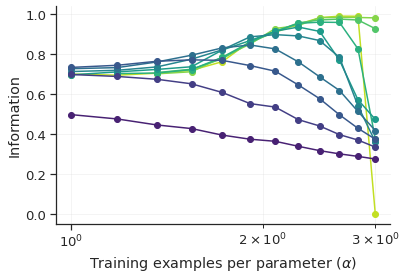

In [ ]:
with sns.color_palette('viridis_r',len(fs)):
    plt.plot(alphas,infos.T,'o-',label=f)
    plt.xlabel(r'Training examples per parameter ($\alpha$)')
    plt.ylabel('Information')
    plt.xscale('log')
    sns.despine()
    plt.grid(which='both',alpha=0.2)